In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
import pandas as pd
import seaborn as sns
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Date pre-processing

In [12]:
#load data
train = np.load("/content/drive/MyDrive/5329Assign1/train_data.npy")
train_label = np.load("/content/drive/MyDrive/5329Assign1/train_label.npy")
test = np.load("/content/drive/MyDrive/5329Assign1/test_data.npy")
test_label = np.load("/content/drive/MyDrive/5329Assign1/test_label.npy")

In [13]:
#doing normalization for input data
epsilon = 1e-15
train_mean = np.mean(train, axis = 0, keepdims = True)
train_var = np.var(train, axis = 0, keepdims = True)
train =(train - train_mean) / np.sqrt(train_var + epsilon)
test_mean = np.mean(test, axis = 0, keepdims = True)
test_var = np.var(test, axis = 0, keepdims = True)
test =(test - test_mean) / np.sqrt(test_var + epsilon)

In [14]:
#translate label into np.array with a size of 50000, 10
#that is to translate the label into the same form of predicts by model
train_real = np.zeros((train_label.shape[0], 10))
for i in range(train_label.shape[0]):
  train_real[i, train_label[i]] = 1
test_real = np.zeros((test_label.shape[0], 10))
for i in range(test_label.shape[0]):
  test_real[i, test_label[i]] = 1

<BarContainer object of 10 artists>

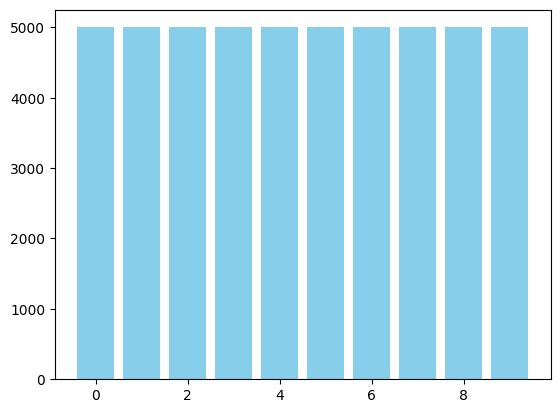

In [15]:
#visulize distribution of train data labels
categories, counts = np.unique(train_label, return_counts=True)
plt.bar(categories, counts, color='skyblue')

<BarContainer object of 10 artists>

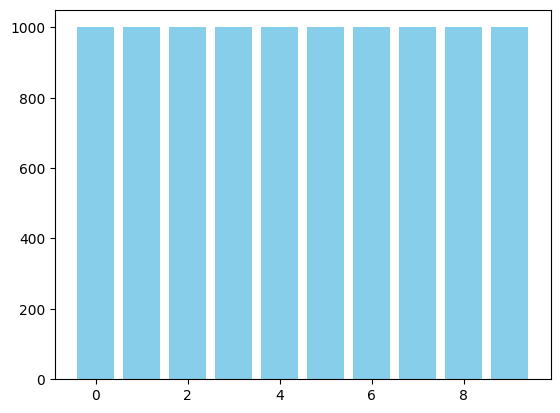

In [ ]:
#visulize distribution of test data labels
categories, counts = np.unique(test_label, return_counts=True)
plt.bar(categories, counts, color='skyblue')

In [ ]:
train.shape

(50000, 128)

#### Model

In [ ]:
#Define activation class
#define relu activation function and derivation
class Activation(object):
  def __relu(self, x):
    return np.maximum(x, 0)

  def __relu_deriv(self, a):
    # a = relu(x)
    a[a <= 0] = 0
    a[a > 0] = 1
    return a

  def __init__(self, activation = 'relu'):
    self.f = self.__relu
    self.f_deriv = self.__relu_deriv

In [ ]:
#Define HiddenLayer
#for example, h1 = HiddenLayer(10, 5, activation_last_layer = "relu", activation = "relu", momentum = 0.9, NAG = True, adagrad = True, miniBatch = 500, batchNorm = True, dropout = 0.5)
# means that we create a layer with 10 dimension input and 5 dimension output, and using relu activation function, using NAG momentum with gamma = 0.9, using adagrad, using batch normalization,
# and 50% of neuros are dropped out during the training process.
class HiddenLayers(object):
  def __init__(self, n_in, n_out, activation_last_layer = 'relu', activation = 'relu', W = None, b = None, momentum = False, NAG = False, adagrad = False, miniBatch = False, batchNorm = False, dropout = 0.0):
    """
    Typical hidden layer of a MLP: units are fully-connected and have
    activation function. Weight matrix W is of shape (n_in,n_out)
    and the bias vector b is of shape (1, n_out).

    Note : The nolinearity used here is relu

    Hidden unit activtion is given by: max(dot(input,W) + b, 0)

    type n_in: int
    param n_in: dimensionality of input

    type n_out: int
    param n_out: idmensionality of output

    type activation_last_layer: string
    param activation_last_layer: activation function of last layer

    type activation: string
    param activation: activation function of current layer

    type W: matrix of float
    param W: pre-set weights

    type b: matrix of float
    param b: pre-set bias

    type momentum: float within 0-1 or False as default value
    param momentum: momentum parameter gamma

    type NAG: bool
    param NAG: if momentum, whether to use NAG or not

    type adagrad: bool
    param adagrad: whether to use adagrad or not

    type miniBatch: int within 0-50000 or False ad default value
    param miniBatch: size of mini-batch

    type batchNorm: bool
    param batchNorm: whether to use batch normlization or not

    type dropout: float within 0-1
    param dropout: rate of dropout for current layer
    """
    #epsilon
    self.epsilon = 1e-15

    self.input = None
    self.activation = Activation(activation).f if activation else None
    #activation deriv of last layer
    self.activation_deriv = None
    if activation_last_layer:
      self.activation_deriv = Activation(activation_last_layer).f_deriv

    #Assign init values for weights
    if not W:
      self.W = np.random.uniform(
        low = -np.sqrt(6. / (n_in + n_out)),
        high = np.sqrt(6. / (n_in + n_out)),
        size = (n_in, n_out)
      )
    else:
      self.W = W

    #Assign init values for bias
    if not b:
      self.b = np.zeros((1, n_out))
    else:
      self.b = b

    #Assign init values for gradations
    self.grad_w = np.zeros(self.W.shape)
    self.grad_b = np.zeros(self.b.shape)

    #store momentum
    self.momentum = momentum
    self.NAG = NAG
    if self.momentum:
      self.V_w = np.zeros(self.W.shape)
      self.V_b = np.zeros((1, n_out))
      if batchNorm:
        self.V_gamma = np.zeros((1, n_out))
        self.V_beta = np.zeros((1, n_out))


    #adagrad, store sum of gradients as lr_w, lr_b, lr_gamma, lr_beta
    self.adagrad = adagrad
    if self.adagrad:
      self.lr_w = np.zeros(self.W.shape)
      self.lr_b = np.zeros((1, n_out))
      self.lr_gamma = np.zeros((1, n_out))
      self.lr_beta = np.zeros((1, n_out))

    #miniBatSize
    self.miniBatch = 1 if not miniBatch else miniBatch

    #batchNorm
    self.batchNorm = batchNorm
    self.running_mean = np.zeros((1, n_out))
    self.running_var = np.zeros((1, n_out))

    #Assign init values for batch normatlization parameters
    self.gamma = np.ones((1, n_out))
    self.beta = np.zeros((1, n_out))
    self.mean = None
    self.var = None
    self.x_hat = None

    #dropout rate
    self.dropout = dropout

  #the forward and backward progress for each training epoch
  def forward(self, input, predict):
    '''
    type input: np.array
    param input: a symboloc tensor of shape
    type predict: bool
    param predict: whether in predict mode or not
    '''
    #Firstly, process NAG
    if self.NAG == True:
      self.W = self.W - self.momentum * self.V_w
      if self.batchNorm:
        self.gamma = self.gamma - self.momentum * self.V_gamma
        self.beta = self.beta - self.momentum * self.V_beta

    #Secondly, calculate outpur of fully connected layer
    output = np.dot(input, self.W) + self.b
    self.input = input

    #dropout process
    if self.dropout > 0 and not predict:
      self.mask = np.random.rand(*output.shape) > self.dropout
      output = output * self.mask
    elif self.dropout > 0 and predict:
      output = output * (1.0 - self.dropout)

    #Thirdly, Batch Normatlization process
    if self.batchNorm and not predict:
      self.mean = np.mean(output, axis = 0, keepdims = True)
      self.var = np.var(output, axis = 0, keepdims = True)
      self.x_hat = (output - self.mean) / np.sqrt(self.var + self.epsilon)
      output = self.gamma * self.x_hat + self.beta

      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
      self.running_var = self.momentum * self.running_var + (1- self.momentum) * self.var
    elif self.batchNorm and predict: #Batch predict
      if not self.momentum:
        self.mean = np.mean(output, axis = 0, keepdims = True)
        self.var = np.var(output, axis = 0, keepdims = True)
        output = self.gamma * ((output - self.mean) / np.sqrt(self.var + self.epsilon)) + self.beta
      else:
        output = self.gamma * ((output - self.running_mean) / np.sqrt(self.running_var + self.epsilon)) + self.beta

    #Finally, activation layer, only relu is processed here, softmax is processed in next Class
    self.output = (
        output if self.activation is None
        else self.activation(output)
    )
    return self.output

  def backward(self, delta, output_layer = False):
    #softmax gradients is calculated in next Class
    #activation gradients are calculated in next layer
    #Firstly, calculate batchNorm gradients.
    if self.batchNorm:
      N = delta.shape[0]
      dx_hat = delta * self.gamma
      dvar = np.sum(dx_hat * (self.output - self.mean) * (-0.5) * (self.var + self.epsilon) ** (-1.5), axis = 0)
      dmean = np.sum(dx_hat * (-1 / np.sqrt(self.var + self.epsilon)), axis = 0) + dvar * np.sum(-2 * (self.output - self.mean), axis = 0) / N
      delta = dx_hat / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.output - self.mean) / N + dmean / N

      self.grad_gamma = np.sum(delta * self.x_hat, axis = 0, keepdims = True)
      self.grad_beta = np.sum(delta, axis = 0, keepdims = True)
      #adagrad process
      if self.adagrad:
        self.lr_gamma += self.grad_gamma ** 2
        self.lr_beta += self.grad_beta ** 2

    #Secondly, calculate gradients of fully connected layer
    if self.batchNorm:
      self.grad_b = np.sum(delta, axis = 0, keepdims = True)
    else:
      if self.miniBatch != 1:
        self.grad_b = np.mean(delta, axis = 0, keepdims = True)
      else:
        self.grad_b = delta

    if self.dropout > 0:
      delta = delta * self.mask

    self.grad_w = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) / self.miniBatch
    #adagrad
    if self.adagrad:
      self.lr_w += self.grad_w ** 2
      self.lr_b += self.grad_b ** 2

    #Finally, calculate gradients of activation function of last layer, the final delta are propogated to the last layer
    if self.activation_deriv:
      delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

    return delta

In [ ]:

#MLP
class MLP:
  #last layer is softmax
  def __init__(self, layers, activation = [None, 'relu', None], momentum = False, NAG = False, adagrad = False, miniBatch = False, weightDecay = 0.0, batchNorm = False, dropout = [0.0, 0.0], earlyStopping = False):
    """
    type layers: A list containing the number of units(int) in each layer
    param layers: should be at least two values

    type activation: A list containing the activation function(string) after each layer
    param activatoin: the activation function to be used, can be relu or None.

    type momentum: float within 0-1 or False as default value
    param momentum: momentum parameter gamma

    type NAG: bool
    param NAG: if momentum, whether to use NAG or not

    type adagrad: bool
    param adagrad: whether to use adagrad or not

    type miniBatch: int within 0-50000 or False ad default value
    param miniBatch: size of mini-batch

    type weightDecay: float within 0-1
    param weightDecay: determine the degree of penalty.

    type batchNorm: bool
    param batchNorm: whether to use batch normlization or not

    type dropout: A list contains float number within 0-1
    param dropout: determine the proportion of dropout

    type earlyStopping: int or False as default
    param earlyStopping: determine after how many epochs the model stops training if the accuracy of test data does not rise.
    """
    #epsilon
    self.epsilon = 1e-15

    #momentum param
    self.momentum = momentum
    self.NAG = NAG

    #adagrad param
    self.adagrad = adagrad

    #MiniBatch param
    self.miniBatch = miniBatch

    #WeightDecay param
    self.weightDecay = weightDecay

    #BatchNorm
    self.batchNorm = batchNorm

    #dropout
    self.dropout = dropout

    #early stopping params
    self.early_stopping_round = earlyStopping
    self.best_validation_accuracy = 0.0
    self.best_epoch = 0
    self.no_improvement_count = 0

    #initialize layers
    self.layers = []
    self.params = []
    self.activation = activation
    for i in range(len(layers)-2):
      #batch normlization and dropout is not applied between the last fully connected layer and softmax activation function
      self.layers.append(HiddenLayers(layers[i], layers[i+1], activation[i], activation[i+1], momentum = self.momentum, NAG = self.NAG, adagrad = self.adagrad, miniBatch = self.miniBatch, batchNorm = self.batchNorm, dropout = self.dropout[i]))
    self.layers.append(HiddenLayers(layers[-2], layers[-1], activation[-2], activation[-1], momentum = self.momentum, NAG = self.NAG, adagrad = self.adagrad, miniBatch = self.miniBatch, batchNorm = False, dropout = False))

  #forward progress
  def forward(self, input, predict = False):
    '''
    type input: np.array
    param input: a symboloc tensor of shape

    type predict: bool
    param predict: whether in predict mode or not
    '''
    for layer in self.layers:
      output = layer.forward(input, predict)
      input = output
    return self.softmax(output)

  #define the softmax and loss function
  def softmax(self, z):
    '''
    type z: np.array
    param z: a symboloc tensor of shape
    '''
    if len(z.shape) == 1: #SGD
      exp_z = np.exp(z - np.max(z))
      return exp_z / np.sum(exp_z)
    else: #MiniBatch SGD
      exp_z = np.exp(z - np.max(z, axis = 1, keepdims = True))
      return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

  def cross_entropy_loss(self, y_hat, y):
    '''
    type y_hat and y: np.array
    '''
    if len(y.shape) == 1: #SGD
      loss = -np.sum(y * np.log(y_hat + self.epsilon))
    else:  #MiniBatch SGD
      loss = -np.mean(np.sum(y * np.log(y_hat + self.epsilon), axis = 1, keepdims = True))
    #delta is the gradients for softmax and cross entropy loss
    delta = y_hat - y

    #WeightDecay
    if self.weightDecay != 0:
      weight_decay_loss = 0
      for layer in self.layers:
        weight_decay_loss += 0.5 * self.weightDecay * np.sum(layer.W ** 2)
      return loss + weight_decay_loss, delta

    return loss, delta

  #backward progress
  def backward(self, delta):
    '''
    type delta: np.array
    param delta: gradients to be passed
    '''
    for layer in reversed(self.layers):
      delta = layer.backward(delta)

  #update the weights
  def update(self, lr):
    '''
    type lr: float within 0-1
    param lr: learning rate
    '''
    for layer in self.layers:
      #adagrad process
      if layer.adagrad:
        lr_w = lr / (np.sqrt(layer.lr_w + self.epsilon))
        lr_b = lr / (np.sqrt(layer.lr_b + self.epsilon))
        if layer.batchNorm:
          lr_gamma = lr / (np.sqrt(layer.lr_gamma + self.epsilon))
          lr_beta = lr / (np.sqrt(layer.lr_beta + self.epsilon))
      else:
        lr_w = lr
        lr_b = lr
        if layer.batchNorm:
          lr_gamma = lr
          lr_beta = lr

      #momentum process
      if self.momentum:
        V_w = self.momentum * layer.V_w + lr_w * layer.grad_w
        layer.V_w = V_w
        V_b = self.momentum * layer.V_b + lr_b * layer.grad_b
        layer.V_b = V_b
        layer.W -= (V_w + self.weightDecay * layer.W) #Weight Decay
        layer.b -= V_b
        if layer.batchNorm:
          V_gamma = self.momentum * layer.V_gamma + lr_gamma * layer.grad_gamma
          layer.V_gamma = V_gamma
          V_beta = self.momentum * layer.V_beta + lr_beta * layer.grad_beta
          layer.V_beta = V_beta
          layer.gamma -= V_gamma
          layer.beta -= V_beta
      else:
        layer.W -= (lr_w * layer.grad_w + self.weightDecay * layer.W) #Weight Decay
        layer.b -= lr_b * layer.grad_b
        if layer.batchNorm:
          layer.gamma -= lr_gamma * layer.grad_gamma
          layer.beta -= lr_beta * layer.grad_beta

  #define the training function
  def fit(self, X, y, learning_rate = 0.1, epochs = 100, validationData = None, validationLabel = None):
    """
    type X: np.array
    param X: Input data

    type y: np.array
    param y: Input targets

    type learning_rate: float within 0-1
    param learning_rate: the speed of learning

    type epochs: int > 0
    param epochs: number of times the dataset is presented to the network for learning

    type validationData and label: np.array
    param validataonData and label: Input validation data and label when using early stopping
    """
    X = np.array(X)
    y = np.array(y)
    #detect training process
    to_return_loss = []
    to_return_accuracy = []

    #SGD
    if not self.miniBatch:
      print("Using SGD")
      for k in range(epochs):
        loss = np.zeros(X.shape[0])
        for it in range(X.shape[0]):
          #Randomly pick sample
          i = np.random.randint(X.shape[0])

          #forward
          y_hat = self.forward(X[i], predict = False)

          #compute loss
          loss[it], delta = self.cross_entropy_loss(y_hat, y[i])

          #backward
          self.backward(delta)

          #updata
          self.update(learning_rate)

        #cal train Accuracy
        accuracy = self.cal_accuracy(X, y)

        #cal test Accuracy and determine whether to break or not
        if self.early_stopping_round > 0:
          test_accuracy = self.cal_accuracy(validationData, validationLabel)
          if self.early_stopping_check(k, test_accuracy):
            break

        to_return_loss.append(np.mean(loss))
        to_return_accuracy.append(accuracy)
        print("epoch:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), accuracy))

    #MiniBatch SGD
    else:
      print("Using MiniBatch SGD")
      for k in range(epochs):
        loss = np.zeros(int(X.shape[0]/self.miniBatch)+1)

        #Randomly pick samples
        shuffled_indices = np.random.permutation(X.shape[0])
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for it in range(0, X.shape[0], self.miniBatch):
          end_idx = min(it + self.miniBatch, X.shape[0])  #avoid index out of range
          Xi = X_shuffled[it:end_idx]
          yi = y_shuffled[it:end_idx]

          #forward
          y_hat = self.forward(Xi, predict = False)

          #comput loss
          loss[int(it/self.miniBatch)], delta = self.cross_entropy_loss(y_hat, yi)

          #backward
          self.backward(delta)

          #update
          self.update(learning_rate)

        #cal train Accuracy
        accuracy = self.cal_accuracy(X, y)

        #cal test Accuracy
        if self.early_stopping_round > 0:
          test_accuracy = self.cal_accuracy(validationData, validationLabel)
          if self.early_stopping_check(k, test_accuracy):
            break

        to_return_loss.append(np.mean(loss))
        to_return_accuracy.append(accuracy)
        print("epoch:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), accuracy))

    return to_return_loss, to_return_accuracy, test_accuracy

  #Early stopping control
  def early_stopping_check(self, current_epoch, validation_accuracy):
    '''
    type current_epoch: int
    param current_epoch: current epoch

    type validataion_accuracy: float within 0-1
    param validation_accuracy: accuracy of current model on test data
    '''
    if not self.early_stopping_round:
      return False

    if validation_accuracy > self.best_validation_accuracy:
      self.best_validation_accuracy = validation_accuracy
      self.best_epoch = current_epoch
      self.no_improvement_count = 0
    else:
      self.no_improvement_count += 1

    if self.no_improvement_count >= self.early_stopping_round:
      print("Stopping at epoch {0}, Best epoch {1}, Best validation accuracy: {2}".format(current_epoch, self.best_epoch, self.best_validation_accuracy))
      return True
    return False

  #tool function, cal accuracy
  def cal_accuracy(self, _x, _y):
    '''
    type _x, _y: np.array
    param _x: input data
    param _y: label of input data
    '''
    correct = 0
    predict = np.argmax(self.predict(_x), axis = 1)
    for i in range(predict.shape[0]):
      if _y[i, predict[i]] == 1:
        correct += 1
    return correct/_x.shape[0]

  #predict fucntion
  def predict(self, x):
    '''
    type x: np.array
    param x: input data
    '''
    output = self.forward(x, predict = True)
    return output


#### Definition of draw graph function and evalutaion metrics


In [ ]:
#calculate evaluation metrics on test data
class Evaluation_metrics():
  def __init__(self, model, test_data, test_label):
    """
    model: Class MLP
    test_data: np.array
    test_label: np.array with a shape(10000, 1)
    """
    self.test_output = model.predict(test_data)
    self.y_pred = np.argmax(self.test_output, axis = 1)
    self.y_true = test_label.reshape(-1)
    self.cm = confusion_matrix(self.y_true, self.y_pred)

  #calculate Accuracy
  def accuracy(self):
    correct = 0
    for i in range(self.y_pred.shape[0]):
      if self.y_pred[i] == self.y_true[i]:
        correct += 1
    return correct / self.y_pred.shape[0]

  #calculate precision
  def precision(self):
    return precision_score(self.y_true, self.y_pred, average='weighted')

  #calculate recall
  def recall(self):
    return recall_score(self.y_true, self.y_pred, average='weighted')

  #calculate f1_score
  def f1_score(self):
    return f1_score(self.y_true, self.y_pred, average='weighted')



In [ ]:
#print accuracy metric for training data
def print_output(loss, accuracy):
  '''
  loss: list containing loss for each epoch
  accuracy: list containing accuracy for each epoch
  '''
  fig, ax1 = plt.subplots()

  ax1.plot(loss, color='blue', label='loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss', color='blue')

  ax2 = ax1.twinx()

  ax2.plot(accuracy, color='red', label='accuracy')
  ax2.set_ylabel('accuracy', color='red')

  plt.title('Train Loss and Accuracy')
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  plt.xticks(ticks=range(0, len(loss)+1, 2))
  plt.show()

In [ ]:
#compare different hyperparameters
def compare_outputs(models_data, para, test_accuracy):
  '''
  models_data: dictionary containing data for each model,
        keys are different hyperparameters, values are tuples (loss, accuracy)
    loss: list containing loss for each epoch
    accuracy: list containing accuracy for each epoch
  para: string, name of hyperparameter. e.g. "learning rate"
  test_accuracy: dictionary containing test accuracy for each model
  '''

  colors = sns.color_palette("Blues_r")

  fig, ax1 = plt.subplots(figsize = (10,6))

  for i, (hyperparameter, (loss, accuracy)) in enumerate(models_data.items()):
    ax1.plot(loss, label=f'{hyperparameter}', color=colors[i])

  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss', color="blue")
  plt.title('Train Loss (solid line) and Accuracy (dashed line) on different {}'.format(para))

  colors = sns.color_palette("Reds_r")
  ax2 = ax1.twinx()
  for i, (hyperparameter, (loss, accuracy)) in enumerate(models_data.items()):
    ax2.plot(accuracy, label=f'{hyperparameter}', color=colors[i], linestyle='--')
  ax2.set_ylabel('accuracy', color = "red")

  test_handles = [plt.Line2D([0], [0], color=colors[i], linestyle='--', markersize=5, label=f'Test Accuracy: {test_accuracies[model]:.2f}') for i, model in enumerate(models_data.keys())]
  plt.legend(handles=test_handles, loc='lower right', bbox_to_anchor=(1, 0))


  fig.legend(loc='upper right')
  plt.xticks(ticks=range(0, len(loss)+1, 2))


  plt.show()


#### Compare different models

In [ ]:
#Compare different models
loss_ablation = []
accuracy_ablation = []
test_accuracy_ablation = []

In [ ]:
# Learning with adjusted hyperparameters
nn = MLP([128, 256, 512, 10], [None, "relu", "relu", None], momentum=0.8, NAG = True, adagrad = True, miniBatch=50000, weightDecay=0.0001, batchNorm=True, dropout = [0, 0.3, 0.3, 0], earlyStopping = 5)
loss, accuracy, test_accuracy = nn.fit(train, train_real, learning_rate=0.01, epochs=200, validationData = test, validationLabel = test_real)

Using MiniBatch SGD
epoch:0,loss:1.3892423987075169,Accuracy:0.12468
epoch:1,loss:3.8903885202491595,Accuracy:0.152
epoch:2,loss:3.315074906819116,Accuracy:0.13694
epoch:3,loss:2.1415691352216393,Accuracy:0.28264
epoch:4,loss:2.2823516354949036,Accuracy:0.3186
epoch:5,loss:2.396964807559852,Accuracy:0.28804
epoch:6,loss:2.265299018988888,Accuracy:0.31104
epoch:7,loss:2.169933191289677,Accuracy:0.35022
epoch:8,loss:1.648294514558247,Accuracy:0.30632
epoch:9,loss:1.6073188770325257,Accuracy:0.30354
epoch:10,loss:1.2695449478757181,Accuracy:0.29838
epoch:11,loss:1.0447011811025664,Accuracy:0.3333
Stopping at epoch 12, Best epoch 7, Best validation accuracy: 0.3373


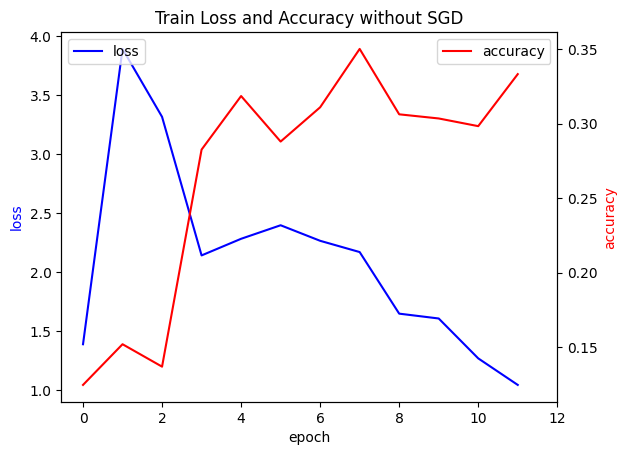

In [ ]:
print_output(loss, accuracy)

In [ ]:
loss_ablation.append(loss)
accuracy_ablation.append(accuracy)
test_accuracy_ablation.append(test_accuracy)
loss_ablation
accuracy_ablation
test_accuracy_ablation

[0.5286, 0.5457, 0.5446, 0.5391]

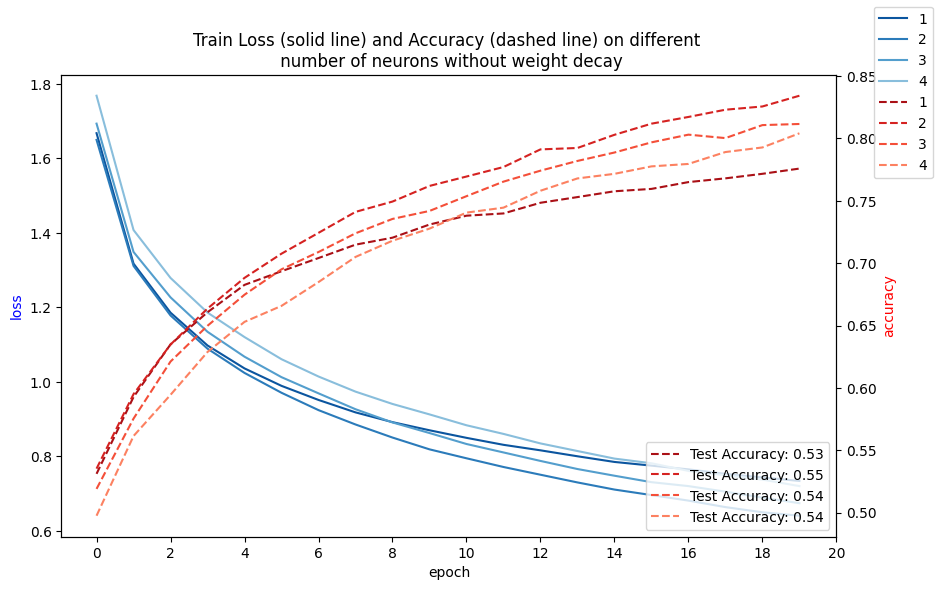

In [ ]:
parameter = [i+1 for i in range(4)]
test_accuracies = {}
models_data = {}
for i in range(len(parameter)):
  models_data[parameter[i]] = (loss_ablation[i], accuracy_ablation[i])
  test_accuracies[parameter[i]] = test_accuracy_ablation[i]
compare_outputs(models_data,"\n number of neurons without weight decay", test_accuracies)

#### Confusion matrix and evaluation metrics

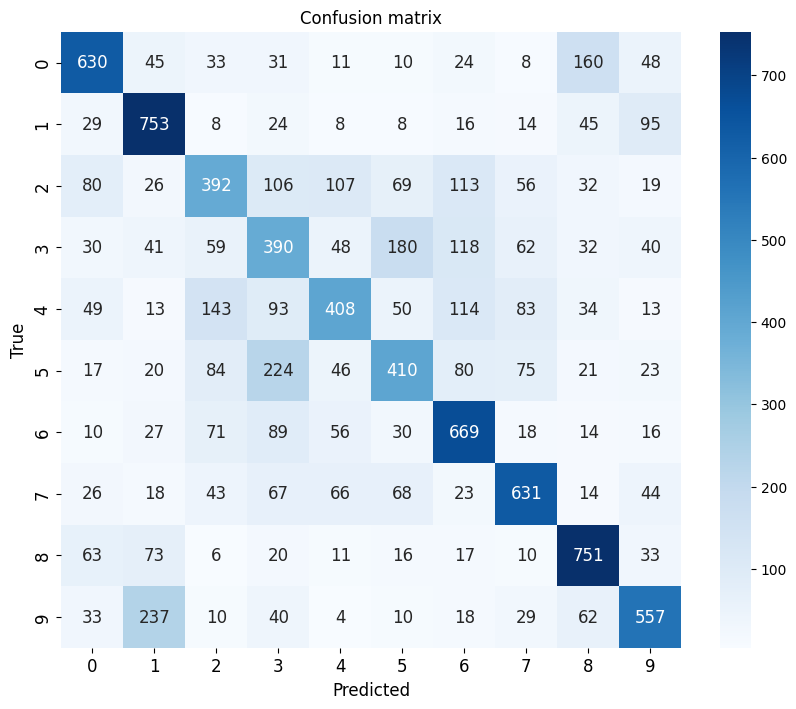

In [ ]:
#draw confusion matrix
Em = Evaluation_metrics(nn, test, test_label)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(Em.cm, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt='d')
plt.ylabel('True', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Confusion matrix')
plt.show()

In [ ]:
#Print evaluation metrics
print('Accuracy', Em.accuracy(), )
print('Weighted precision', Em.precision())
print('Weighted recall', Em.recall())
print('Weighted f1-score', Em.f1_score())

Accuracy 0.5591
Weighted precision 0.556216340790511
Weighted recall 0.5591
Weighted f1-score 0.554228781435309


#### Compare models with different hyperparameters

In [ ]:
#Compare models with different hyperparameters
loss_list = []
accuracy_list = []
test_accuracy_list = []
parameter = [0.0001, False]
for i in parameter:
  nn = MLP([128, 256, 512, 10], [None, "relu", "relu", None], momentum=0.8, NAG = True, adagrad = True, miniBatch=50, weightDecay=i, batchNorm=True, dropout = [0, 0.3, 0.3, 0], earlyStopping = 50)
  loss, accuracy, test_accuracy = nn.fit(train, train_real, learning_rate=0.01, epochs=20, validationData = test, validationLabel = test_real)
  loss_list.append(loss)
  accuracy_list.append(accuracy)
  test_accuracy_list.append(test_accuracy)
test_accuracies = {}
models_data = {}

Using MiniBatch SGD
epoch:0,loss:1.8990239925886088,Accuracy:0.55072
epoch:1,loss:1.5428906144925507,Accuracy:0.60434
epoch:2,loss:1.4306415003294581,Accuracy:0.62882
epoch:3,loss:1.3517930544738361,Accuracy:0.6584
epoch:4,loss:1.2851312038427016,Accuracy:0.68118
epoch:5,loss:1.2396193643733737,Accuracy:0.69006
epoch:6,loss:1.1945242775253866,Accuracy:0.71402
epoch:7,loss:1.1533827364847522,Accuracy:0.72452
epoch:8,loss:1.1207765407259702,Accuracy:0.73586
epoch:9,loss:1.097144325218394,Accuracy:0.74504
epoch:10,loss:1.064544635128826,Accuracy:0.7475
epoch:11,loss:1.046427315193941,Accuracy:0.76324
epoch:12,loss:1.0264351597270387,Accuracy:0.7683
epoch:13,loss:1.0035092965032582,Accuracy:0.7711
epoch:14,loss:0.9896969682036648,Accuracy:0.7738
epoch:15,loss:0.9745166640231794,Accuracy:0.7655
epoch:16,loss:0.962339465487042,Accuracy:0.77608
epoch:17,loss:0.9495450465351204,Accuracy:0.78166
epoch:18,loss:0.9397576292843774,Accuracy:0.78234
epoch:19,loss:0.9282714683767079,Accuracy:0.78634


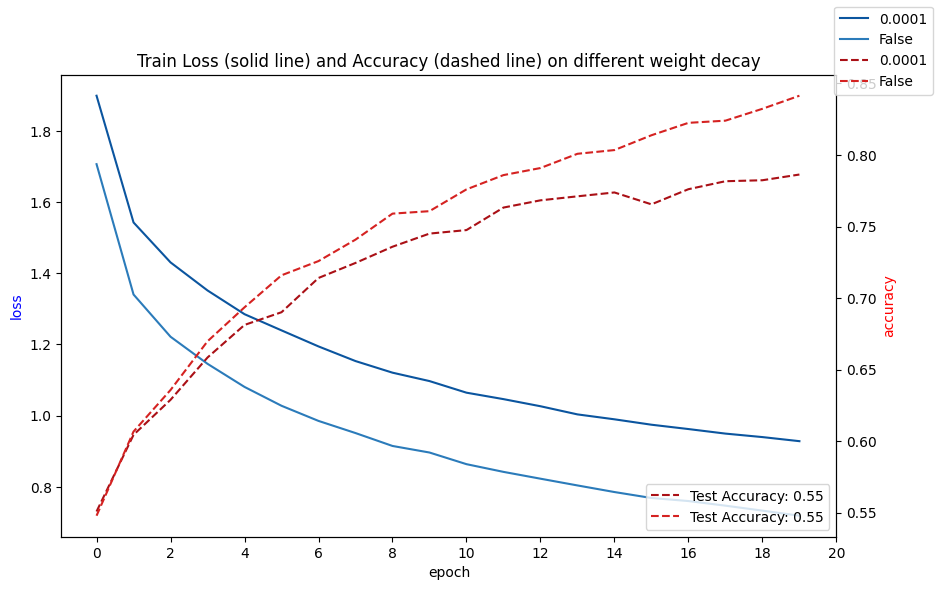

In [ ]:
for i in range(len(parameter)):
  models_data[parameter[i]] = (loss_list[i], accuracy_list[i])
  test_accuracies[parameter[i]] = test_accuracy_list[i]
compare_outputs(models_data,"weight decay", test_accuracies)

#### Test run speed for different bacth size

In [ ]:
#Test run speed for different bacth size
sizes = [i for i in range(50, 5000, 100)]
time_batchsize = {}
for i in sizes:
  start_time = time.time()
  nn = MLP([128, 256, 512, 10], [None, "relu", "relu", None], momentum=0.8, NAG = True, adagrad = True, miniBatch=i, weightDecay=False, batchNorm=True, dropout = [0, 0.3, 0.3, 0], earlyStopping = 50)
  loss, accuracy, test_accuracy = nn.fit(train, train_real, learning_rate=0.01, epochs=5, validationData = test, validationLabel = test_real)
  end_time = time.time()
  execution_time = end_time - start_time
  time_batchsize[i] = execution_time/5


Using MiniBatch SGD
epoch:0,loss:1.7111202432510941,Accuracy:0.54192
epoch:1,loss:1.3357922065861232,Accuracy:0.60834
epoch:2,loss:1.221348271388902,Accuracy:0.64468
epoch:3,loss:1.1390371681537326,Accuracy:0.66816
epoch:4,loss:1.0741099541957282,Accuracy:0.6944
Using MiniBatch SGD
epoch:0,loss:1.7000405592322048,Accuracy:0.53552
epoch:1,loss:1.3123949164417872,Accuracy:0.60926
epoch:2,loss:1.1734099629303065,Accuracy:0.65098
epoch:3,loss:1.0835115754794846,Accuracy:0.68426
epoch:4,loss:1.0105784056024796,Accuracy:0.70226
Using MiniBatch SGD
epoch:0,loss:1.7237104541990826,Accuracy:0.55478
epoch:1,loss:1.292547583444421,Accuracy:0.61792
epoch:2,loss:1.151239476789059,Accuracy:0.65718
epoch:3,loss:1.059057460216307,Accuracy:0.6905
epoch:4,loss:0.9844379590445252,Accuracy:0.71558
Using MiniBatch SGD
epoch:0,loss:1.7588800670140718,Accuracy:0.54818
epoch:1,loss:1.3044999549066045,Accuracy:0.61116
epoch:2,loss:1.167929648733222,Accuracy:0.65088
epoch:3,loss:1.0704597533301492,Accuracy:0.69

Text(0, 0.5, 'Run Time(s)')

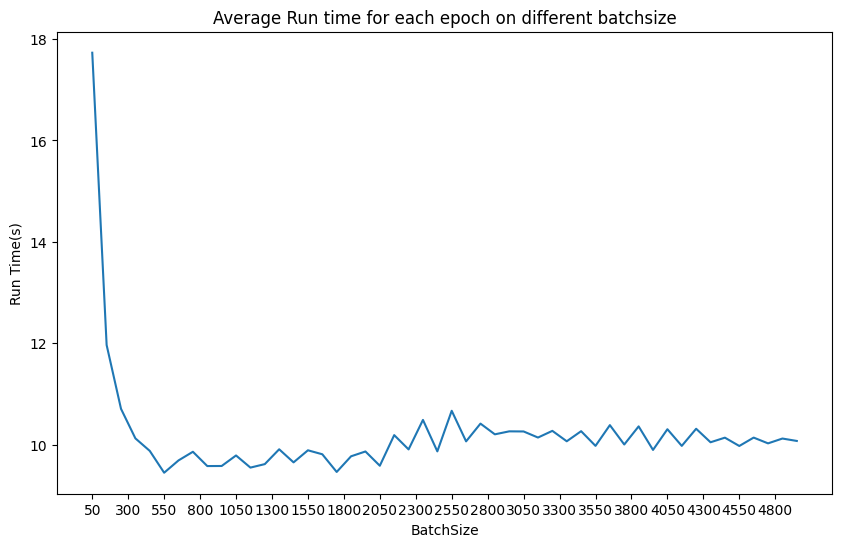

In [ ]:
x_values = list(time_batchsize.keys())
y_values = list(time_batchsize.values())
plt.figure(figsize = (10, 6))
plt.plot(x_values, y_values)

plt.title('Average Run time for each epoch on different batchsize')
plt.xlabel('BatchSize')
plt.xticks([i for i in range(50, 5000, 250)])
plt.ylabel('Run Time(s)')